In [ ]:
#hide
import sys
sys.path.append('..')

In [ ]:
#hide
from chitra.core import *

# Chitra

> Library for creating data input pipeline in pure Tensorflow 2.x

.
<!-- This file will become your README and also the index of your documentation. -->

## Install

`pip install chitra`

## How to use

<!-- Fill me in please! Don't forget code examples: -->
## Loading data for image classification

class names: (b'blackcat', b'whitecat')


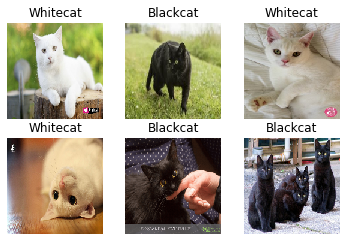

In [ ]:
from chitra.dataloader import Clf, show_batch

path = '/Users/aniketmaurya/Pictures/cats'

clf_dl = Clf()
data = clf_dl.from_folder(path)

print('class names:', clf_dl.CLASS_NAMES)

show_batch(data, 6, (6,6))